<h2>Data Prep</h2>
<h4>read data</h4>

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt

df_org=pd.read_csv('US_Accidents_Dec20_updated.csv',sep=',')
df_org.head(1)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2716600,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.10891,-83.09286,40.11206,-83.03187,3.23,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night


In [3]:
print(df_org.dtypes)

ID                        object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity   

<h4>missing value</h4>
check the percentage of missing values in each column and the combination of columns


In [17]:
def check_missing(df_org):
    missing_num=df_org[df_org.isna().any(axis=1)].shape[0]
    missing_per=missing_num/df_org.shape[0]
    print('-- %d rows(%.2f) have one ore more missing values in one of the columns'%(missing_num,missing_per*100))
    for col in df_org.columns:
        missing_num=df_org[df_org[col].isna()].shape[0]
        if missing_num!=0:
            missing_per=missing_num/df_org.shape[0]
            print('-- %d rows(%.2f) have missing value in column %s'%(missing_num,missing_per*100,col))

#check_missing(df_org)

<h4>choose_columns</h4>
choose_columns wanted in the analysis(inluding converting datetime to date, etc.)

In [24]:
def choose_columns(df_org,columns_list,rename_dict):
    df1=df_org[columns_list].copy()
    df1.rename(columns=rename_dict,inplace=True)
    #insert the date of the accidents to the dataframe
    df1.insert(0,'date',pd.to_datetime(df_org['Start_Time']).dt.date)
    return df1
    
columns_list=['ID','State','City','Temperature(F)','Visibility(mi)','Wind_Speed(mph)','Weather_Condition']
rename_dict={'State':'state','City':'city',
             'Temperature(F)':'temperature','Wind_Speed(mph)':'wind_speed',
             'Visibility(mi)':'visibility','Weather_Condition':'weather_condition'}
columns_list.remove('Wind_Speed(mph)')
del rename_dict['Wind_Speed(mph)']
df1=choose_columns(df_org,columns_list,rename_dict)
df1.head(3)

,date,ID,state,city,temperature,visibility,weather_condition
0,2016-02-08,A-2716600,OH,Dublin,42.1,10.0,Light Rain
1,2016-02-08,A-2716601,OH,Dayton,36.9,10.0,Light Rain
2,2016-02-08,A-2716602,OH,Cincinnati,36.0,10.0,Overcast


In [25]:
check_missing(df1)

-- 54891 rows(3.62) have one ore more missing values in one of the columns
-- 83 rows(0.01) have missing value in column city
-- 43033 rows(2.84) have missing value in column temperature
-- 44211 rows(2.92) have missing value in column visibility
-- 44007 rows(2.90) have missing value in column weather_condition


<h4> select data</h4>
select data only in the wanted area(state or city)

In [34]:
def select_data(df,column=None,value_list=None):
    #df
    #column: str, the column you want to use as the filter
    #value_list: list, the value that you want to keep in the new dataframe
    print('shape of original dataframe:',df.shape)
    #Use all data(no data selection)
    if column is None:
        print('No data selection!')
        return df
    elif value_list is None:
        print('Did not pass value list!')
        return df
    else:
        df_new=df[df[column].isin(value_list)].copy()
        print('shape of new dataframe:',df_new.shape,'(%.2f)'%(100*df_new.shape[0]/df.shape[0]))
        return df_new
df2=select_data(df1,'city',['Los Angeles'])
df2.head(3)


shape of original dataframe: (1516064, 7)
shape of new dataframe: (39984, 7) (2.64)


,date,ID,state,city,temperature,visibility,weather_condition
5360,2016-03-22,A-2721960,CA,Los Angeles,64.0,10.0,Clear
5364,2016-03-22,A-2721964,CA,Los Angeles,64.0,10.0,Clear
5379,2016-03-23,A-2721979,CA,Los Angeles,55.9,10.0,Clear


<h4>group data</h4>
<p>group data by date(or date and city, etc.), and apply one-hot encoding on 'weather_condition'</p>
<p>For temperature: Find the lowest and highest temperature of all accidents within that day</p>
<p>For visibility: Find the lowest visibility</p>
<p>For wind speed: Find the highest wind speed</p>
<p>For weather condition: get the doomy variables of all weather conditions, and use max on each condition. Namely, if a weather condition appears during any of the accident taken place that day, then the value of that weather condition is set to 1(otherwise 0)</p>

In [53]:
def group_df(df,group_factor,weather_condition_list=None):
    # group factor: str/list, group df by one or more columns
    #weather_condition_list:list, use when we only want to include part of the 
    #                       weather conditions(the most frequent ones) in our model
    onehot=pd.get_dummies(df['weather_condition'])
    if weather_condition_list is not None:
        onehot=onehot[weather_condition_list]
    df_new=df.join(onehot)
    df_new=df_new.drop('weather_condition',axis=1)
    #group df
    agg_dict={'ID':'count','temperature':['min','max'],'visibility':'min','wind_speed':'max'}
    column_name_dict={'ID':'accident_counts','temperature':['highest_temp','lowest_temp'],
                      'visibility':'min_visibility','wind_speed':'max_wind_speed'}
    key_list=list(agg_dict.keys())
    for k in key_list:
        if k not in df.columns:
            del agg_dict[k]
            del column_name_dict[k]
    column_name=[]
    for v in column_name_dict.values():
        if type(v)==str:
            column_name.append(v)
        elif type(v)==list:
            column_name+=v
    for col in onehot.columns:
        agg_dict[col]='max'
        column_name.append(col)
    df_new2=df_new.groupby(group_factor).agg(agg_dict)
    #rename columns
    df_new2.columns=column_name
    return df_new2
    
df3=group_df(df2,'date')
df3.head(3)


,accident_counts,highest_temp,lowest_temp,min_visibility,Blowing Dust,Clear,Cloudy,Fair,Fair / Windy,Fog,...,Partly Cloudy,Partly Cloudy / Windy,Patches of Fog,Rain,Scattered Clouds,Shallow Fog,Smoke,T-Storm,Thunder,Thunderstorm
date,,,,,,,,,,,,,,,,,,,,,
2016-03-22,2,64.0,64.0,10.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-03-23,22,55.9,75.0,10.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-03-24,10,53.1,80.1,10.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2>Build Model</h2>

check missing value

In [62]:
check_missing(df3)
print(df3.shape)
df3=df3[~df3.isna().any(axis=1)]
print(df3.shape)

-- 2 rows(0.13) have one ore more missing values in one of the columns
-- 2 rows(0.13) have missing value in column highest_temp
-- 2 rows(0.13) have missing value in column lowest_temp
-- 2 rows(0.13) have missing value in column min_visibility
(1552, 30)
(1550, 30)


<h4> Poisson Regression Model</h4>

The percentage of deviance explained by the model is 0.6830999246157121
params:
 3.321357559869568 
 [-0.07615484  0.05665579 -0.0350937  -0.00659631 -0.32800407  0.11810245
  0.65915633  0.0007995   0.08457561 -0.07099269  0.18285986  0.15743909
  0.          0.37449002  0.0222354   0.00463351  0.19214422  0.
 -0.04092893  0.11975419  0.          0.0028103   0.12777906  0.1856021
  0.03023274 -0.0968792   0.15743909  0.01238433 -0.00554997]


/Users/yiwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


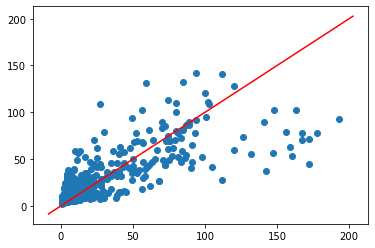

In [63]:
def Poisson(df):
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    regr = linear_model.PoissonRegressor()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    test_score = regr.score(X_test, y_test)
    coef = regr.coef_
    intercept = regr.intercept_
    print('The percentage of deviance explained by the model is',test_score)
    print('params:\n',intercept,'\n',coef)
    
    #draw plots
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
         ]
    ax.plot(lims,lims,'r')
    
Poisson(df3)
    
    